<h1>Fitting IVT mechanistic model to Akama dataset<h1>

In this notebook, we will be showing how the figures in our paper were generated. We will be doing the following
    
    1. Performing local MAP optimization to fit our model to the dataset of Akama et al.
    2. Using a linearized model approximation to estimate a parameter covariance matrix. 
    3. Visualizing model fitting by plotting against fitting dataset
    4. Validating our model on new data (without fitting parameters)

<b>1. Importing required packages<b>

In [1]:
using Pkg
Pkg.activate("IVTmodel")
Pkg.instantiate()
using Distributed
using DifferentialEquations
using Plots
using NLopt
using LinearAlgebra
using Metrics
using CSV, DataFrames
using StaticArrays
using ForwardDiff
using NamedTupleTools
using BenchmarkTools
using ComponentArrays
using Distributions
using Statistics
using GenericLinearAlgebra
using DiffResults
using FLoops
using SharedArrays
using Plots.PlotMeasures
using FlexiMaps
using LaTeXStrings
using DelimitedFiles
using StatsBase
using NLsolve
using BenchmarkTools

include("./modules/model.jl")
include("./modules/parameterbackend.jl")
include("./modules/akamadataprocessing.jl")
include("./modules/akamaplotting.jl")
include("./modules/IVTplotting.jl")
include("./modules/modelfitting.jl")
include("./modules/residualcalculation.jl")
include("./modules/parameteruncertainty.jl")
include("./modules/predictionuncertainty.jl")
include("./modules/akamasensitivity.jl");

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVTmechanisticmodel\IVTmodel`
Precompiling project...
  ? Metrics
Precompiling Metrics
        Info Given Metrics was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Metrics
[ Info: Precompiling Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78].
┌ Warning: Replacing docs for `Metrics.bin_to_cat :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `Metrics.confusion_matrix :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing do

<b>2: Setting up model and importing data<b>

The following cell creates an object representing the parameters used in our model, whether they are fitted parameters or not, and their Bayesian priors. 
    
We also import required data for fitting and validation. 

In [2]:
#Generates settings for parameters used
fittingmodel = setupmodel()
#Imports calibration data from csv files
modeldata = importakamadata()
#Imports PPiase validation data
PPiasedata = importakamaPPiasedata();

<b>3: Optimizing Model<b>
    
We next fit the model to the Akama data set using MAP estimation. While in our work multistart optimization was used for this nonconvex problem, we use a local optimization here for simplicity. We will use a manually selected starting point that is near the optimum but not optimal.  

In [3]:
#Start at a manually selected warm start point
modorigin = [
  3.93
  5.13
  3.71
  2.30
 -3.692
 -3.8
 -4.50
  #0 #If using "ppiaseuncertainty = true" uncomment this line
 #-3.6695 #If using "ppiaseuncertainty = true" uncomment this line
 -0.26
  1.65
  4.47
  6.91
  2.08
  9.02
  3.30
  6.91
  2.08
  4.22
  1.84
  5.23
  3.99
 -3.95
]
modoriginparams = fullparameterset(fittingmodel,modorigin)
printresidual(fittingmodel,modeldata,modorigin) #Print loss of parameters applied to data.

Total Residual:                        1490.2
Components of residual:
Concentration Trajectories (Figure 2): 838.2
Initial Reaction Rate (Figure 3A):     169.5
Mg2PPi solubility (Figure 3B):         363.9
Parameter priors:                      118.7


We then optimize the model and calculate a covariance matrix. Note that the loss should be decreasing until a tolerance is reached. 

In [4]:
optim=localopt(fittingmodel, modeldata,300,modorigin,akamaresidual,verbose = true)
fittedparamslist = optim[4]
fittedparams = fullparameterset(fittingmodel,fittedparamslist)
covariancemat = getcovariancematrix(fittingmodel,modeldata,fittedparamslist);
writedlm( "outputs/fittedparameters.csv",  fittedparamslist, ',')
writedlm( "outputs/covariancematrix.csv",  covariancemat, ',')
printresidual(fittingmodel,modeldata,fittedparamslist)

1490.2451880641167


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\ChemeGrad2021\.julia\packages\SciMLBase\slQep\src\integrator_interface.jl:583
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\ChemeGrad2021\.julia\packages\SciMLBase\slQep\src\integrator_interface.jl:583


46756.2984526244
32965.01262811419
4723.514404530568
1227.4480850611621
1199.693722002584
1100.4493734458072
1019.5459501783389
950.9291658365781
940.6499593822982
935.016180999359
931.4124464276927
912.6293549184459
897.4977527403421
886.8094283662468
885.9941381661356
883.1627179004789
879.3132662580088
873.2722621934076
865.3785285452363
860.8609088807693
858.7832984110823
857.2222190419941
854.6507253439065
848.0323393267286
847.554331365431
840.4295824454938
836.6855825294206
831.2991190905502
828.7303899585892
827.9484667256463
827.4271991684618
827.1047082075934
825.9823785429653
824.9410242730943
823.915860956697
823.606355665817
823.403787911223
823.174260418118
822.723436571994
822.0917320636565
821.2263122625322
820.2157376155617
819.7729552895374
819.427758405076
819.0624318118151
818.9447236523315
818.9088125888122
818.894312960856
818.876606189314
818.857080758217
818.8332912668907
818.8127972005601
818.8013307172205
818.7771237839199
818.7481901866104
818.7004259369836
8

We can investigate the source of the loss between the datasets used in our calibration set. In this case, residuals are roughly proportional to the amount of "information" we get from each source. 

<b>4: Plotting Figures from Paper - Fitting Data<b>
    
Now that we have have successfully fit a set of parameters to our model, we can think about plotting our data alongside our model predictions. 

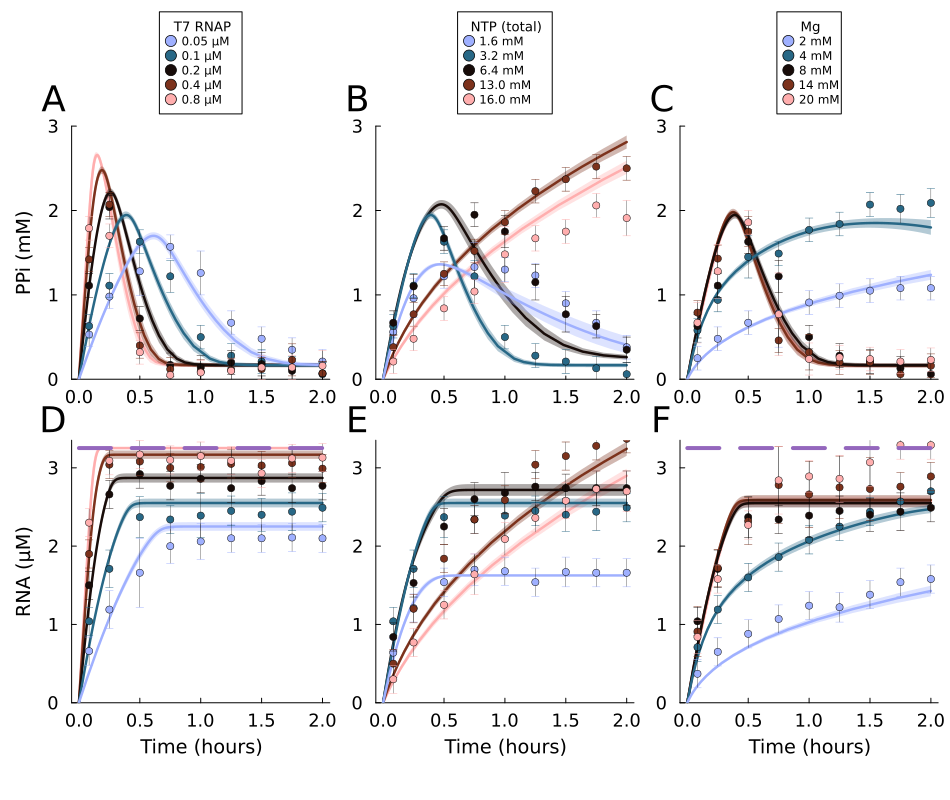

In [5]:
plt = revision1plot1(fittingmodel,modeldata, fittedparams, covariancemat, true,true)
savefig(plt,"figures/SIfigure2.pdf")
plt

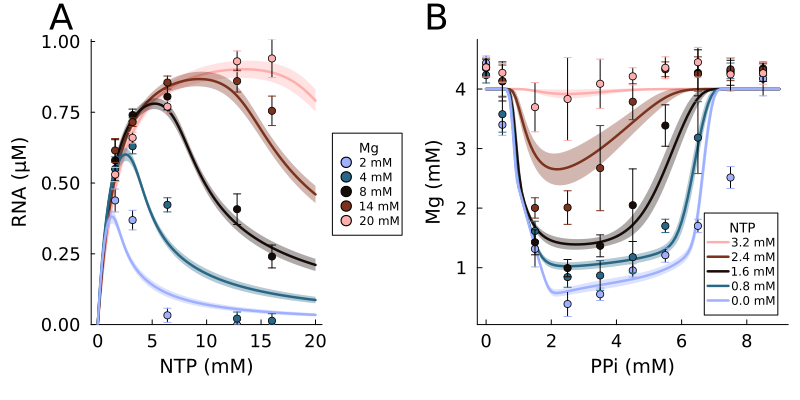

In [6]:
plt = revision1plot2(fittingmodel,modeldata, fittedparams, covariancemat, true,true)
savefig(plt,"figures/SIfigure3.pdf")
plt

<b>5: Plotting Figures from Paper - Validation Data<b>
    
Finally, we can apply our model to new data. See the main body of our paper for a complete description of what this data represents.

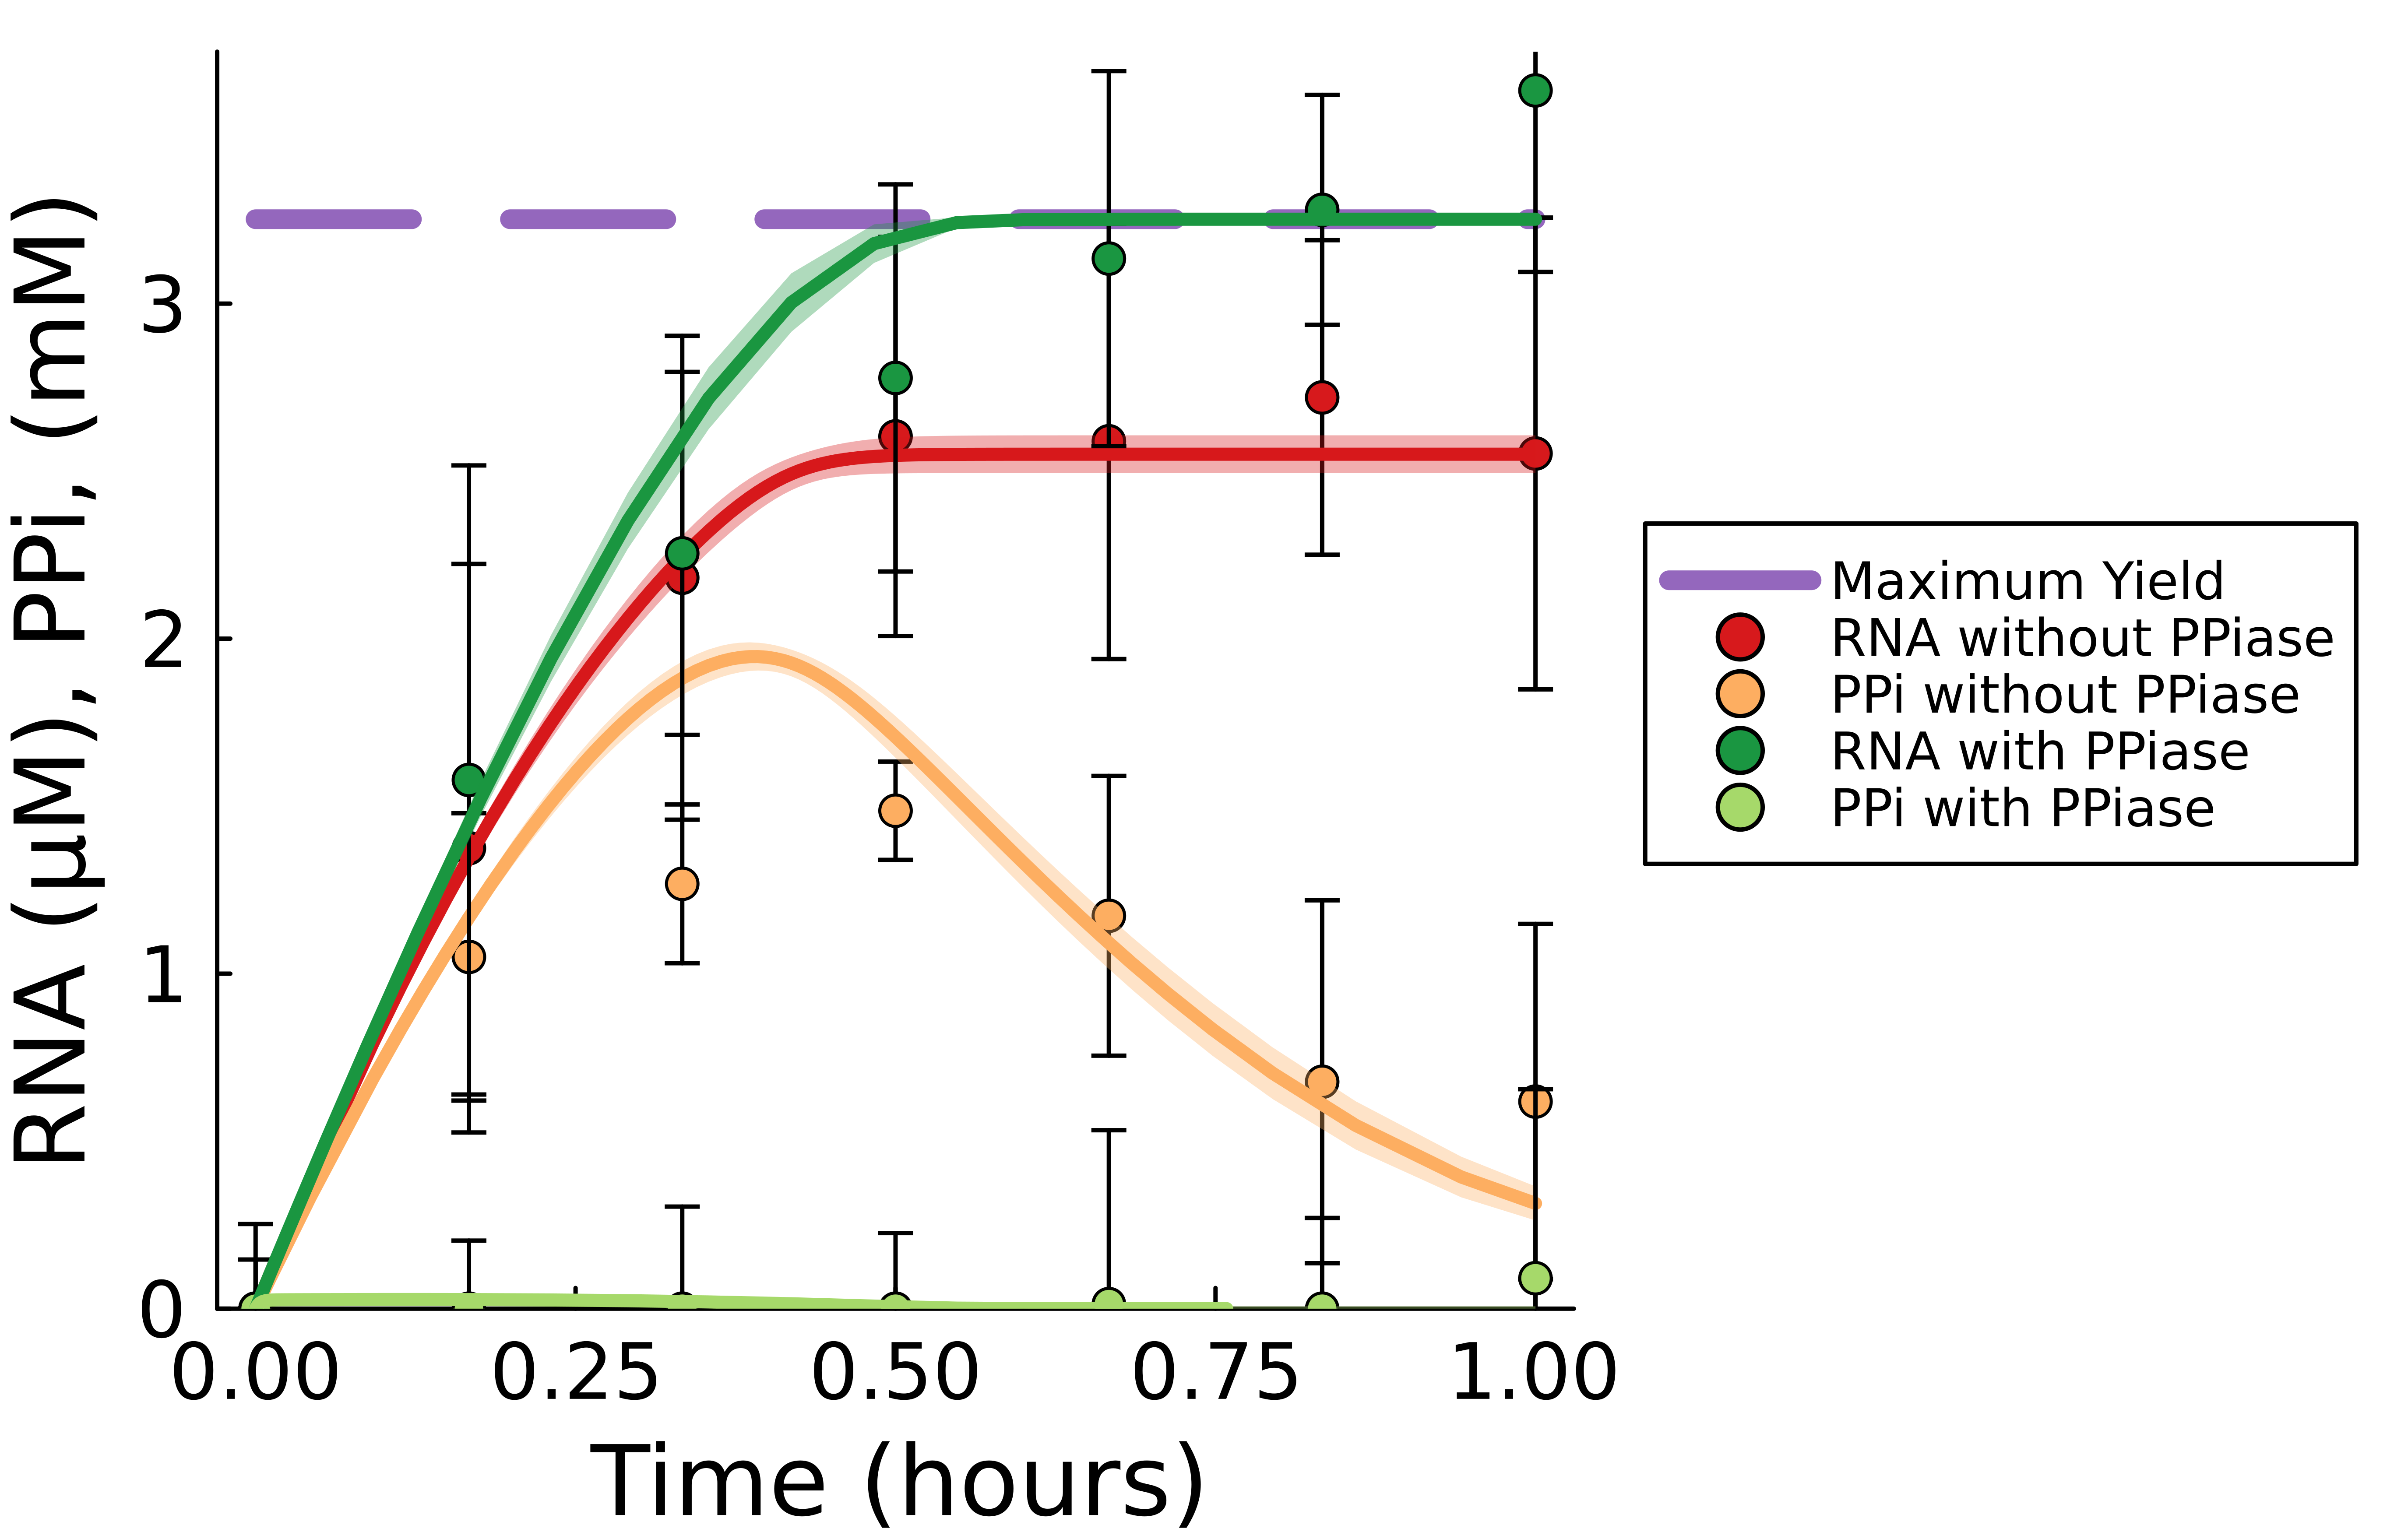

In [7]:
plt= plotakamaPPiase(PPiasedata, fittedparams, covariancemat,fittingmodel)
plot!(dpi = 1000)
savefig(plt,"figures/SIfigure4.pdf")
plt

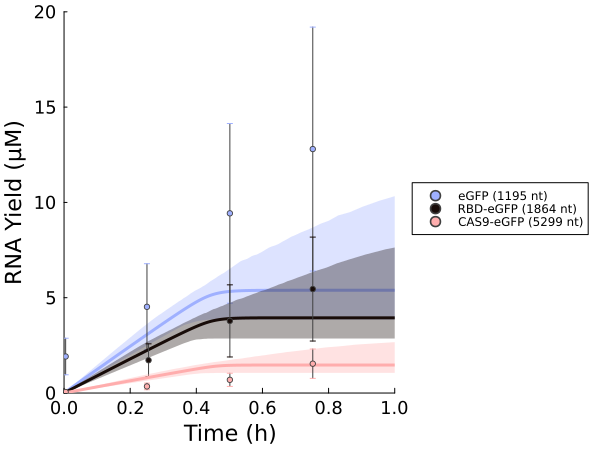

In [8]:
plt = plotfromcsv(fittingmodel,fittedparamslist,covariancemat,"data/rosadata.csv",range = [1,2,3],plotsize = (600,450),labels = ["eGFP (1195 nt)", "RBD-eGFP (1864 nt)", "CAS9-eGFP (5299 nt)"],dataerrorbars = true, multiplot = false,maximumyield = false)
plot!(xlims = (0,1),ylims = (0,20))
savefig(plt,"figures/SIfigure5.pdf")
plt